# Detectron2: Microcontroller Instance Segmentation
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


## Get data

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/detectron2-microcontroller/dataset-use-case/annotations

use_case_0.xml	 use_case_25.xml  use_case_40.xml  use_case_56.xml
use_case_10.xml  use_case_26.xml  use_case_41.xml  use_case_57.xml
use_case_11.xml  use_case_27.xml  use_case_42.xml  use_case_58.xml
use_case_12.xml  use_case_28.xml  use_case_43.xml  use_case_59.xml
use_case_13.xml  use_case_29.xml  use_case_44.xml  use_case_5.xml
use_case_14.xml  use_case_2.xml   use_case_45.xml  use_case_60.xml
use_case_15.xml  use_case_30.xml  use_case_46.xml  use_case_61.xml
use_case_16.xml  use_case_31.xml  use_case_47.xml  use_case_62.xml
use_case_17.xml  use_case_32.xml  use_case_48.xml  use_case_63.xml
use_case_18.xml  use_case_33.xml  use_case_49.xml  use_case_64.xml
use_case_19.xml  use_case_34.xml  use_case_4.xml   use_case_6.xml
use_case_1.xml	 use_case_35.xml  use_case_50.xml  use_case_7.xml
use_case_20.xml  use_case_36.xml  use_case_51.xml  use_case_8.xml
use_case_21.xml  use_case_37.xml  use_case_52.xml  use_case_9.xml
use_case_22.xml  use_case_38.xml  use_case_53.xml
use_case_23.xml  us

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2
import xml.etree.ElementTree as ET


# write a function that loads the dataset into detectron2's standard format
def get_dataset_dicts(annotation_path, image_path):
    classes = ['actor', 'oval', 'line', 'text', 'arrow', 'system']

    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(annotation_path)):
        record = {}
        root = ET.parse(os.path.join(annotation_path, filename)).getroot()
        record["file_name"] = os.path.join(image_path, root.find('filename').text)
        # record["height"] = 3120
        # record["width"] = 4160

        objs = []
        for member in root.findall('object'):
          obj = {
              'bbox': [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text), int(member[4][3].text)],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': classes.index(member[0].text),
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['actor', 'oval', 'line', 'text', 'arrow', 'system']

DatasetCatalog.register('use_case_dataset', lambda: get_dataset_dicts('/content/drive/MyDrive/detectron2-microcontroller/dataset-use-case/annotations', '/content/drive/MyDrive/detectron2-microcontroller/dataset-use-case/images'))
MetadataCatalog.get('use_case_dataset').set(thing_classes=classes)
chess_metadata = MetadataCatalog.get('use_case_dataset')

We can check if our code works correctly by plotting a few images.

In [7]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('use_case_dataset')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=chess_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('use_case_dataset',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/31 20:36:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:06, 38.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[01/31 20:36:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/31 20:36:48 d2.utils.events]:  eta: 0:17:08  iter: 19  total_loss: 2.598  loss_cls: 1.534  loss_box_reg: 0.8312  loss_rpn_cls: 0.09216  loss_rpn_loc: 0.1403  time: 1.2985  data_time: 0.7192  lr: 0.00039962  max_mem: 3197M
[01/31 20:37:13 d2.utils.events]:  eta: 0:17:03  iter: 39  total_loss: 1.762  loss_cls: 0.7425  loss_box_reg: 0.8361  loss_rpn_cls: 0.05573  loss_rpn_loc: 0.1113  time: 1.2705  data_time: 0.5916  lr: 0.00079922  max_mem: 3197M
[01/31 20:37:35 d2.utils.events]:  eta: 0:16:41  iter: 59  total_loss: 1.389  loss_cls: 0.4707  loss_box_reg: 0.742  loss_rpn_cls: 0.03297  loss_rpn_loc: 0.09984  time: 1.2120  data_time: 0.4519  lr: 0.0011988  max_mem: 3197M
[01/31 20:37:58 d2.utils.events]:  eta: 0:16:39  iter: 79  total_loss: 0.8981  loss_cls: 0.2968  loss_box_reg: 0.5082  loss_rpn_cls: 0.01074  loss_rpn_loc: 0.1091  time: 1.1995  data_time: 0.5089  lr: 0.0015984  max_mem: 3197M
[01/31 20:38:21 d2.utils.events]:  eta: 0:16:39  iter: 99  total_loss: 0.7712  loss_cls: 0.254

## Save the model in Google Drive


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!ls /content/gdrive/MyDrive/

detectron2-microcontroller  detectron2_use_case_model.pth  phd


In [13]:
model_save_name = 'detectron2_uml_model.pth'
path = F"/content/drive/MyDrive/{model_save_name}"
torch.save(trainer.model.state_dict(), path)

In [15]:
config_name = 'config.yml'
path_config = F"/content/drive/MyDrive/{config_name}"
f = open(path_config, 'w')
f.write(cfg.dump())
f.close()

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [1]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
cfg.DATASETS.TEST = ("use_case_dataset", )
predictor = DefaultPredictor(cfg)

NameError: ignored

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


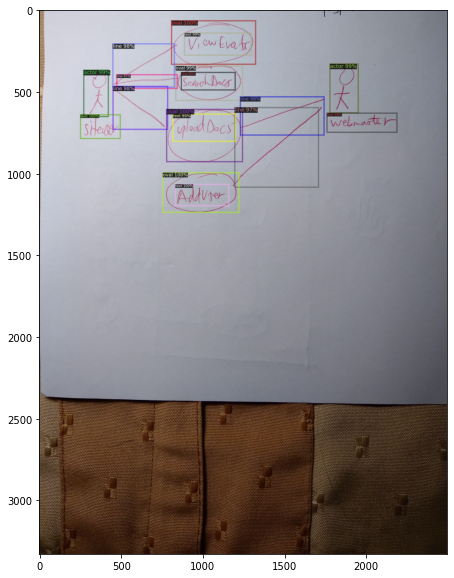

In [32]:
img_test = "/content/drive/MyDrive/detectron2-microcontroller/test/use_case_6.jpg"
im = cv2.imread(img_test)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], metadata=chess_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('use_case_dataset')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=chess_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Save config

In [17]:
print(cfg.dump())


CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST: []
  TRAIN:
  - use_case_dataset
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbo

In [19]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

## Export model

In [12]:
!pip install onnx==1.8.1

In [21]:
import argparse
import os
import onnx

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.export import Caffe2Tracer

output = "models"

os.makedirs(output, exist_ok=True)

# create a torch model
torch_model = build_model(cfg)
DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)

# get a sample data

data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
first_batch = next(iter(data_loader))

tracer = Caffe2Tracer(cfg, torch_model, first_batch)

OSError: ignored

## Export to caffe2

In [54]:
# convert and save caffe2 model
caffe2_model = tracer.export_caffe2()
caffe2_model.save_protobuf(output)
# draw the caffe2 graph
caffe2_model.save_graph(os.path.join(output, "model.svg"), inputs=first_batch)

[01/28 21:20:32 d2.export.caffe2_export]: Exporting a Caffe2GeneralizedRCNN model via ONNX ... Some warnings from ONNX are expected and are usually not to worry about.


/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))


RuntimeError: ignored

## Export to ONNX

In [16]:
import torch
torch.cuda.empty_cache()
import onnx

onnx_model = tracer.export_onnx()
onnx.save(onnx_model, os.path.join(output, "model.onnx"))

NameError: ignored